<div class="alert alert-info">
<h1><center><font color=darkblue> DỰ ĐOÁN BỆNH TIM BẰNG LOGISTIC REGRESSION.<font></center></h1>


</div>

## <font color=RoyalBlue>Import<font>

**Mục tiêu:**
- Xác định các yếu tố có liên quan đến bệnh tim
- Xây mô hình dự đoán nguy cơ tổng thể

**Phương pháp:** Logistic regression


In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.mlab as mlab
%matplotlib inline

## <font color=RoyalBlue>Data Preparation<font>


In [2]:
url = "https://raw.githubusercontent.com/GauravPadawe/Framingham-Heart-Study/master/framingham.csv"
heart_df=pd.read_csv(url, on_bad_lines='skip')
heart_df.drop(['education'], axis=1, inplace=True) #k liên quan
heart_df.head()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [3]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4240 non-null   int64  
 1   age              4240 non-null   int64  
 2   currentSmoker    4240 non-null   int64  
 3   cigsPerDay       4211 non-null   float64
 4   BPMeds           4187 non-null   float64
 5   prevalentStroke  4240 non-null   int64  
 6   prevalentHyp     4240 non-null   int64  
 7   diabetes         4240 non-null   int64  
 8   totChol          4190 non-null   float64
 9   sysBP            4240 non-null   float64
 10  diaBP            4240 non-null   float64
 11  BMI              4221 non-null   float64
 12  heartRate        4239 non-null   float64
 13  glucose          3852 non-null   float64
 14  TenYearCHD       4240 non-null   int64  
dtypes: float64(8), int64(7)
memory usage: 497.0 KB


### <font color=CornflowerBlue>Biến :<font>

**<font color=SteelBlue>Biến Categorical:<font>**

- male, currentSmoker
- BPMeds: bệnh nhân có đang dùng thuốc điều trị huyết áp hay không
- prevalentStroke: bệnh nhân trước đây có bị đột quỵ hay không
- prevalentHyp: bệnh nhân có bị tăng huyết áp hay không
- diabetes: bệnh nhân có mắc bệnh tiểu đường hay không

**<font color=SteelBlue>Biến Continuous:<font>**

-  age, cigsPerDay
- totChol: cholesterol level
-  sysBP: systolic blood pressure
-  diaBP: diastolic blood pressure
-  BMI: Body Mass Index
-  heartRate: heart rate
-  glucose: glucose level

**<font color=SteelBlue>Biến phụ thuộc:<font>**

TenYearCHD: Nguy cơ mắc bệnh tim mạch vành 10 năm


In [4]:
heart_df.rename(columns={'male':'Sex_male'},inplace=True)

### <font color=CornflowerBlue>Null values<font>

In [5]:
heart_df.isnull().sum() #số null của từng cột

Sex_male             0
age                  0
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [6]:
count=0
for i in heart_df.isnull().sum(axis=1):
    if i>0:
        count=count+1
print('Tổng số record có null value: ', count)
print('Tỉ lệ số record có null value trong df:',round((count/len(heart_df.index))*100), '%')

Tổng số record có null value:  489
Tỉ lệ số record có null value trong df: 12 %


Có nhiều cách xử lý null value, trong trường hợp này số record có null value chiếm tỉ lệ không lớn, có thể drop các record chứa null.

In [7]:
heart_df.dropna(axis=0,inplace=True) #im lazy

## <font color=RoyalBlue>Exploratory Analysis<font>

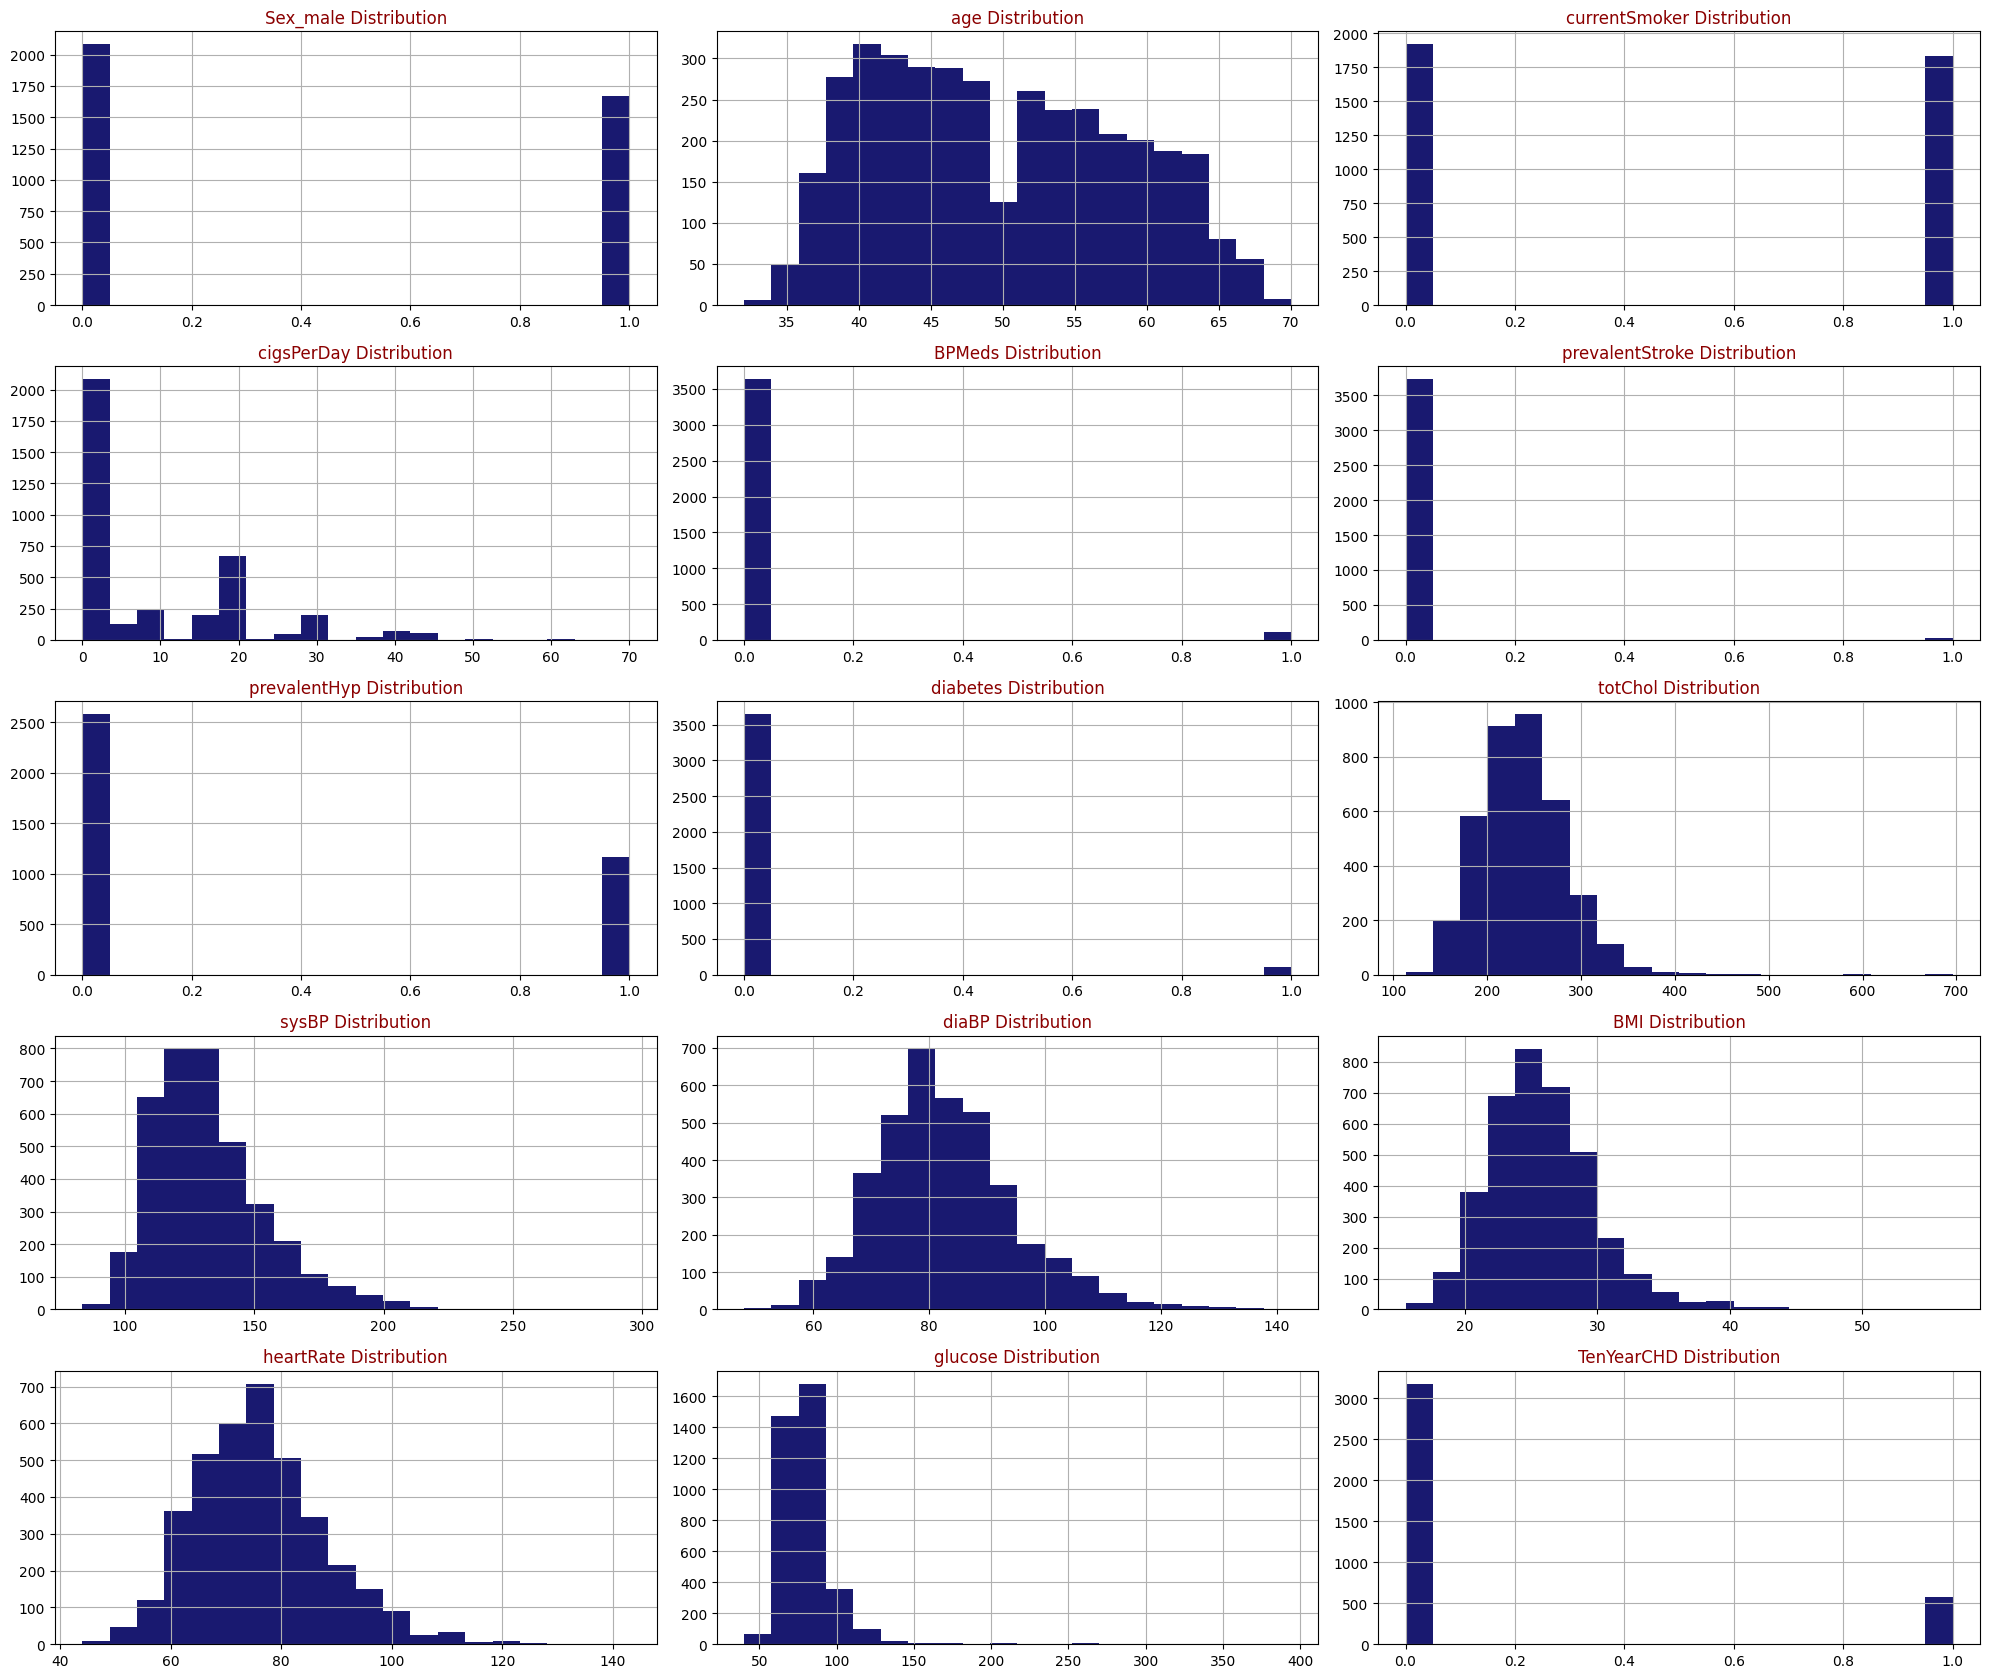

In [8]:
def draw_histograms(dataframe, features, rows, cols): #copy từ github:)
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=20,ax=ax,facecolor='midnightblue')
        ax.set_title(feature+" Distribution",color='DarkRed')

    fig.tight_layout()
    plt.show()
draw_histograms(heart_df,heart_df.columns,6,3)

In [9]:
heart_df.TenYearCHD.value_counts() #đếm số người có nguy cơ bị bệnh tim

0    3179
1     572
Name: TenYearCHD, dtype: int64

<Axes: xlabel='TenYearCHD', ylabel='count'>

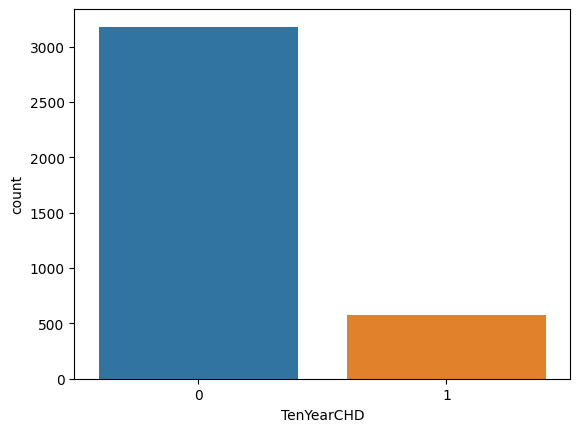

In [10]:
sns.countplot(x='TenYearCHD',data=heart_df)

In [11]:
heart_df.describe() #chi tiết mỗi attribute

,Sex_male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000
mean,0.445215,49.573447,0.488403,9.008531,0.030392,0.005599,0.311917,0.027193,236.928019,132.368435,82.938550,25.808288,75.704079,81.880032,0.152493
std,0.497056,8.570204,0.499932,11.925097,0.171686,0.074623,0.463338,0.162666,44.611594,22.046522,11.932779,4.065599,11.956382,23.882233,0.359546
min,0.000000,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,113.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.085000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.410000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,264.000000,144.000000,90.000000,28.060000,82.000000,87.000000,0.000000
max,1.000000,70.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


## <font color=RoyalBlue>Logistic Regression<font>

In [12]:
from statsmodels.tools import add_constant as add_constant
heart_df_constant = add_constant(heart_df) #thêm cột const vào đầu bảng
heart_df_constant.head()

,const,Sex_male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1.0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,1.0,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1.0,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,1.0,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,1.0,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


**Tạo model logistic regression với statsmodels.api.Logit**

In [13]:
st.chisqprob = lambda chisq, df: st.chi2.sf(chisq, df)
cols=heart_df_constant.columns[:-1] #lấy tất cả các attribute trừ TenYearCHD
cols

Index(['const', 'Sex_male', 'age', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose'],
      dtype='object')

In [14]:
model=sm.Logit(heart_df.TenYearCHD,heart_df_constant[cols])
result=model.fit() #model fit
result.summary() #chi tiết thông số


Optimization terminated successfully.
         Current function value: 0.377036
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 3751
Model:                          Logit   Df Residuals:                     3736
Method:                           MLE   Df Model:                           14
Date:                Sun, 05 Nov 2023   Pseudo R-squ.:                  0.1170
Time:                        07:55:11   Log-Likelihood:                -1414.3
converged:                       True   LL-Null:                       -1601.7
Covariance Type:            nonrobust   LLR p-value:                 2.439e-71
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -8.6532      0.687    -12.589      0.000     -10.000      -7.306
Sex_male            0.5742      0.107      5.345      0.000       0.364       0.785
age                 0.0641      0.007      9.799      0.000       0.051       0.077
currentSmoker       0.0739      0.155      0.478      0.633      -0.229       0.377
cigsPerDay          0.0184      0.006      3.000      0.003       0.006       0.030
BPMeds              0.1448      0.232      0.623      0.533      -0.310       0.600
prevalentStroke     0.7193      0.489      1.471      0.141      -0.239       1.678
prevalentHyp        0.2142      0.136      1.571      0.116      -0.053       0.481
diabetes            0.0022      0.312      0.007      0.994      -0.610       0.614
totChol             0.0023      0.001      2.081      0.037       0.000       0.004
sysBP               0.0154      0.004      4.082      0.000       0.008       0.023
diaBP              -0.0040      0.006     -0.623      0.533      -0.016       0.009
BMI                 0.0103      0.013      0.827      0.408      -0.014       0.035
heartRate          -0.0023      0.004     -0.549      0.583      -0.010       0.006
glucose             0.0076      0.002      3.409      0.001       0.003       0.012
===================================================================================
"""

Một số thuộc tính có p-value lớn (>0.05)


### <font color=CornflowerBlue>Chọn thuộc tính: Backward elemination (dựa vào P-value)<font>

Backward elemination:
- loại bỏ từng thuộc tính có P-value cao nhất
- chạy hồi quy cho đến khi tất cả các thuộc tính có P-value nhỏ hơn 0,05


In [15]:
def back_feature_elem (data_frame,dep_var,col_list):

    while len(col_list)>0 :
        model=sm.Logit(dep_var,data_frame[col_list])
        result=model.fit(disp=0)
        largest_pvalue=round(result.pvalues,3).nlargest(1)
        if largest_pvalue[0]<(0.05):
            return result
            break
        else:
            col_list=col_list.drop(largest_pvalue.index)

result1=back_feature_elem(heart_df_constant,heart_df.TenYearCHD,cols)

In [16]:
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 3751
Model:                          Logit   Df Residuals:                     3744
Method:                           MLE   Df Model:                            6
Date:                Sun, 05 Nov 2023   Pseudo R-squ.:                  0.1149
Time:                        07:55:11   Log-Likelihood:                -1417.7
converged:                       True   LL-Null:                       -1601.7
Covariance Type:            nonrobust   LLR p-value:                 2.127e-76
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.1264      0.468    -19.504      0.000     -10.043      -8.209
Sex_male       0.5815      0.105      5.524      0.000       0.375       0.788
age            0.0655      0.006     10.343      0.000       0.053       0.078
cigsPerDay     0.0197      0.004      4.805      0.000       0.012       0.028
totChol        0.0023      0.001      2.106      0.035       0.000       0.004
sysBP          0.0174      0.002      8.162      0.000       0.013       0.022
glucose        0.0076      0.002      4.574      0.000       0.004       0.011
==============================================================================
"""

In [17]:
result1.params

const        -9.126396
Sex_male      0.581482
age           0.065454
cigsPerDay    0.019702
totChol       0.002271
sysBP         0.017377
glucose       0.007588
dtype: float64

#### <font color=darkblue>Logistic regression equation<font>

$$P=\hspace{.2cm}e^{\beta_0 + \beta_1 X_1}\hspace{.2cm}/\hspace{.2cm}1+e^{\beta_0 +\beta_1 X_1}$$




## <font color=RoyalBlue>Xử lý kết quả<font>

In [18]:
params = np.exp(result1.params) #odd ratio = e^coeff
conf = np.exp(result1.conf_int()) #CI 95% (2.5% và 97.5%)
pvalue=round(result1.pvalues,3)

conf['Odds Ratio'] = params #thêm cột odd ratio vào
conf['pvalue']=pvalue #thêm cột pvalue
conf.columns = ['CI 95%(2.5%)', 'CI 95%(97.5%)', 'Odds Ratio','pvalue']
conf


,CI 95%(2.5%),CI 95%(97.5%),Odds Ratio,pvalue
const,0.000043,0.000272,0.000109,0.000
Sex_male,1.455242,2.198536,1.788687,0.000
age,1.054483,1.080969,1.067644,0.000
cigsPerDay,1.011733,1.028128,1.019897,0.000
totChol,1.000158,1.004394,1.002273,0.035
sysBP,1.013292,1.021784,1.017529,0.000
glucose,1.004346,1.010898,1.007617,0.000


**Kết quả cho thấy, với đk giữ nguyên các yếu tố khác không đổi:**

 - Tỷ lệ được chẩn đoán mắc bệnh tim ở nam giới (Sex_male = 1) so với tỷ lệ mắc bệnh tim ở nữ giới (Sex_male = 0) là 1,788687. Xét về phần trăm thay đổi, chúng ta có thể nói rằng tỷ lệ  ở nam cao hơn 78,8% so với tỷ lệ  ở nữ.

 - Coefficient của age cho thấy tỷ lệ được chẩn đoán mắc bệnh CDH tăng 7% khi tuổi tăng thêm một năm vì odds ratio = 1,067644.

 - Tương tự, với mỗi điếu thuốc hút thêm, tăng 2% nguy cơ mắc CDH.

 - Đối với mức cholesterol và mức glucose không có sự thay đổi đáng kể.

 - Tỷ lệ tăng lên là 1,7% khi sysBP tăng lên một đơn vị.

### <font color=CornflowerBlue>Splitting data to train and test split<font>

In [30]:
import sklearn
x=heart_df_constant.iloc[:,:-1]
y=heart_df_constant.iloc[:,-1]
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.20,random_state=5)

In [31]:
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression()
logreg.fit(x_train,y_train)
y_pred=logreg.predict(x_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Using the new features for prediction model

In [21]:
new_features=heart_df[['age','Sex_male','cigsPerDay','totChol','sysBP','glucose','TenYearCHD']]
x_new=new_features.iloc[:,:-1]
y_new=new_features.iloc[:,-1]
from sklearn.model_selection import train_test_split
x_train2,x_test2,y_train2,y_test2=train_test_split(x_new,y_new,test_size=.20,random_state=5)

In [27]:
from sklearn.linear_model import LogisticRegression
logreg_new=LogisticRegression()
logreg_new.fit(x_train2,y_train2)
y_pred2=logreg_new.predict(x_test2)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## <font color=RoyalBlue>Model Evaluation<font>

### <font color=CornflowerBlue>Model accuracy<font>

In [32]:
sklearn.metrics.accuracy_score(y_test,y_pred)

0.8801597869507324

<font color=DarkBlue>Độ chính xác của model là 0.88<font>

In [28]:
sklearn.metrics.accuracy_score(y_test2,y_pred2)

0.8748335552596538

<font color=DarkBlue>Độ chính xác của model là 0.875<font>

In [ ]:
####  <font color=DarkBlue>Khi loại bỏ các attribute, độ chính xác của model giảm.<font>

Như vậy tuy có p-value thấp, những giá trị bị loại bỏ vẫn có ảnh hưởng đến khả năng mắc bệnh CDH của bệnh nhân.

### <font color=CornflowerBlue>Confusion matrix<font>

<Axes: >

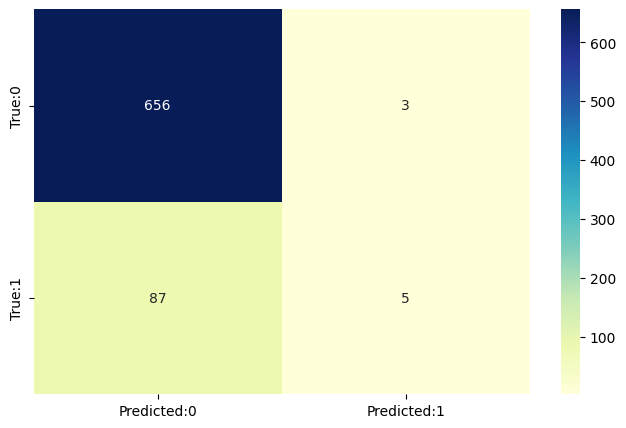

In [33]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['True:0','True:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

Confusion matrix hiển thị 656+5 = 661 dự đoán đúng và 87+3= 90 dự đoán sai.

**True Positives:**  656<font>

**True Negatives:**  5<font>

**False Positives:** 3 (*Type I error*)<font>

**False Negatives:** 87 ( *Type II error*)<font>

In [34]:
#Gán vào biến để tính toán
TN=cm[0,0]
TP=cm[1,1]
FN=cm[1,0]
FP=cm[0,1]
sensitivity=TP/float(TP+FN)
specificity=TN/float(TN+FP)


print("True Positive Rate (TPR)", TP/float(TP+FN),'\n')
print("False Positive Rate (FPR)", TP/float(TP+FN),'\n')

True Positive Rate (TPR) 0.05434782608695652 

False Positive Rate (FPR) 0.05434782608695652 



### <font color=CornflowerBlue>Model evaluation - Statistics<font>

In [35]:
print('The acuuracy of the model = TP+TN/(TP+TN+FP+FN) = ',(TP+TN)/float(TP+TN+FP+FN),'\n',

'The Missclassification = 1-Accuracy = ',1-((TP+TN)/float(TP+TN+FP+FN)),'\n',

'Sensitivity (True Positive Rate) = TP/(TP+FN) = ',TP/float(TP+FN),'\n',

'Specificity (True Negative Rate) = TN/(TN+FP) = ',TP/float(TP+FN),'\n',

'Positive Predictive value = TP/(TP+FP) = ',TP/float(TP+FP),'\n',

'Negative predictive Value = TN/(TN+FN) = ',TN/float(TN+FN),'\n',

'Positive Likelihood Ratio = Sensitivity/(1-Specificity) = ',sensitivity/(1-specificity),'\n',

'Negative likelihood Ratio = (1-Sensitivity)/Specificity = ',(1-sensitivity)/specificity)


The acuuracy of the model = TP+TN/(TP+TN+FP+FN) =  0.8801597869507324 
 The Missclassification = 1-Accuracy =  0.11984021304926762 
 Sensitivity (True Positive Rate) = TP/(TP+FN) =  0.05434782608695652 
 Specificity (True Negative Rate) = TN/(TN+FP) =  0.05434782608695652 
 Positive Predictive value = TP/(TP+FP) =  0.625 
 Negative predictive Value = TN/(TN+FN) =  0.882907133243607 
 Positive Likelihood Ratio = Sensitivity/(1-Specificity) =  11.938405797101462 
 Negative likelihood Ratio = (1-Sensitivity)/Specificity =  0.949976802757158


**Từ số liệu thống kê trên, rõ ràng mô hình có tính specific hơn sensitive. Giá trị negative được dự đoán chính xác hơn giá trị positive.**

### <font color=CornflowerBlue>Xác suất dự đoán đối với test data  (alpha = 0,5)<font>

In [36]:
y_pred_prob=logreg.predict_proba(x_test)[:,:]
y_pred_prob_df=pd.DataFrame(data=y_pred_prob, columns=['Tỉ lệ không bị bệnh tim (0)','Tỉ lệ bị bệnh tim (1)'])
y_pred_prob_df.head()

,Tỉ lệ không bị bệnh tim (0),Tỉ lệ bị bệnh tim (1)
0,0.880578,0.119422
1,0.926518,0.073482
2,0.877431,0.122569
3,0.841158,0.158842
4,0.898692,0.101308


**Giảm threshold<font>**

Vì mô hình dự đoán bệnh tim nên có quá nhiều False Negative là không nên. Kết quả False Negative (bỏ qua khả năng mắc bệnh khi thực tế có bệnh) nguy hiểm hơn False Positive.

Do đó để tăng sensitivity, alpha có thể được giảm xuống.

In [37]:
from sklearn.preprocessing import binarize
for i in range(1,5):
    cm2=0
    y_pred_prob_yes=logreg.predict_proba(x_test)
    y_pred2=binarize(y_pred_prob_yes, threshold=i/10)[:,1]
    cm2=confusion_matrix(y_test,y_pred2)
    print('Với alpha=',i/10,', Confusion Matrix: ','\n',cm2)
    print('với',cm2[0,0]+cm2[1,1],'dự đoán đúng và',cm2[1,0],'False Negatives')
    print('Sensitivity: ',cm2[1,1]/(float(cm2[1,1]+cm2[1,0])),'Specificity: ',cm2[0,0]/(float(cm2[0,0]+cm2[0,1])),'\n\n\n')


Với alpha= 0.1 , Confusion Matrix:  
 [[263 396]
 [ 18  74]]
với 337 dự đoán đúng và 18 False Negatives
Sensitivity:  0.8043478260869565 Specificity:  0.3990895295902883 



Với alpha= 0.2 , Confusion Matrix:  
 [[502 157]
 [ 51  41]]
với 543 dự đoán đúng và 51 False Negatives
Sensitivity:  0.44565217391304346 Specificity:  0.7617602427921093 



Với alpha= 0.3 , Confusion Matrix:  
 [[603  56]
 [ 72  20]]
với 623 dự đoán đúng và 72 False Negatives
Sensitivity:  0.21739130434782608 Specificity:  0.9150227617602428 



Với alpha= 0.4 , Confusion Matrix:  
 [[641  18]
 [ 84   8]]
với 649 dự đoán đúng và 84 False Negatives
Sensitivity:  0.08695652173913043 Specificity:  0.9726858877086495 





### **ROC curve**

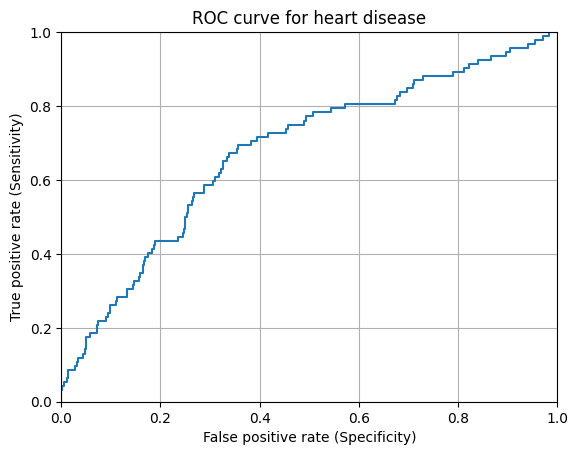

In [43]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_yes[:,1])
plt.plot(fpr,tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for heart disease')
plt.xlabel('False positive rate (Specificity)')
plt.ylabel('True positive rate (Sensitivity)')
plt.grid(True)

Area under the ROC curve

In [44]:
sklearn.metrics.roc_auc_score(y_test,y_pred_prob_yes[:,1])

0.6760902553275715

## <font color=RoyalBlue>...


#### Source data

https://raw.githubusercontent.com/GauravPadawe/Framingham-Heart-Study/master/framingham.csv

